In [67]:
import pandas as pd
import os

In [68]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("aljarah/xAPI-Edu-Data")

# print("Path to dataset files:", path)

In [69]:
df_path = r"C:\Users\Fhuan\OneDrive\Escritorio\ProyectoFinalBigDataG2\dataset.csv"
df = pd.read_csv(df_path)
display(df)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [70]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

In [71]:
# Reemplazar valores vacíos por NaN
df.replace(["?", "NA", "None", ""], pd.NA, inplace=True)

In [72]:
# ============================================================
#   LIMPIEZA + MODELADO + GRÁFICOS (NUEVO DATASET)
#   Python 3.13.7
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# 1. ---------- LIMPIEZA DEL DATASET ----------
# ============================================================

# Convertir todas las columnas de texto a minúsculas limpias
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Eliminar duplicados
df = df.drop_duplicates()

# Reemplazar valores nulos
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("unknown")
    else:
        df[col] = df[col].fillna(df[col].median())

# Manejo de outliers numéricos
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
    p1 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=p1, upper=p99)

# ============================================================
# 2. ---------- VARIABLES ----------
# ============================================================

TARGET = "Target"  # NUEVO target

X = df.drop(columns=[TARGET])
y = df[TARGET]

categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Codificación
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# ============================================================
# 3. ---------- MODELO ----------
# ============================================================

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)
# ============================================================
#     IMPORTANCIA DE VARIABLES — SOLUCIÓN DEFINITIVA
# ============================================================

# Obtener nombres completos luego del preprocessing
full_feature_names = pipeline.named_steps["preprocess"].get_feature_names_out()

# Obtener importancias del modelo
importances = pipeline.named_steps["model"].feature_importances_

# Crear DataFrame
feat_imp = pd.DataFrame({
    "feature": full_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top10 = feat_imp.head(10)

print("\n=== TOP 10 FEATURES ===")
print(top10)

y_pred = pipeline.predict(X_test)

print("\n=== REPORT ===")
print(classification_report(y_test, y_pred))




=== TOP 10 FEATURES ===
                                        feature  importance
28     num__Curricular units 2nd sem (approved)    0.115249
29        num__Curricular units 2nd sem (grade)    0.101525
22     num__Curricular units 1st sem (approved)    0.077894
23        num__Curricular units 1st sem (grade)    0.071375
27  num__Curricular units 2nd sem (evaluations)    0.050605
17                       num__Age at enrollment    0.047005
21  num__Curricular units 1st sem (evaluations)    0.045725
14                 num__Tuition fees up to date    0.039207
10                     num__Father's occupation    0.038847
3                                   num__Course    0.038815

=== REPORT ===
              precision    recall  f1-score   support

     dropout       0.81      0.74      0.78       355
    enrolled       0.63      0.38      0.47       199
    graduate       0.79      0.95      0.86       552

    accuracy                           0.78      1106
   macro avg       0.74    

C:\Users\Fhuan\AppData\Local\Temp\ipykernel_19048\4063297673.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Target", data=df, palette="Set2")


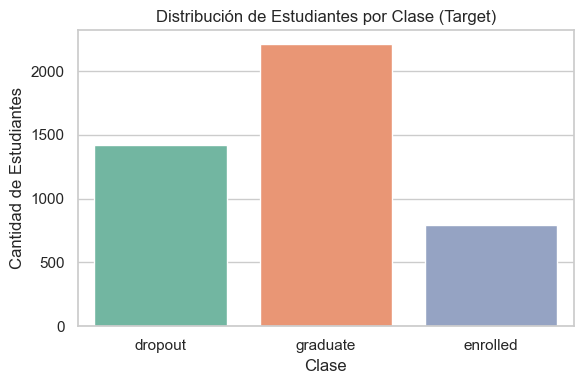

C:\Users\Fhuan\AppData\Local\Temp\ipykernel_19048\4063297673.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Target", y="Age at enrollment", data=df, palette="Set3")


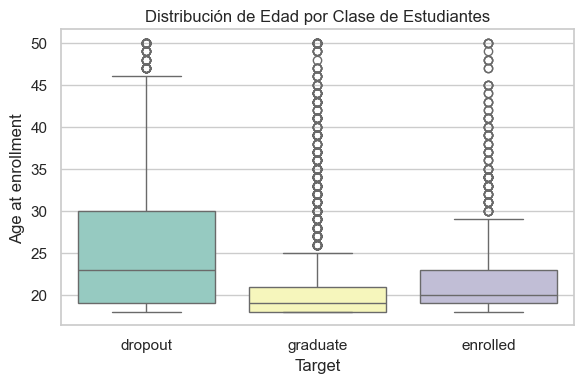

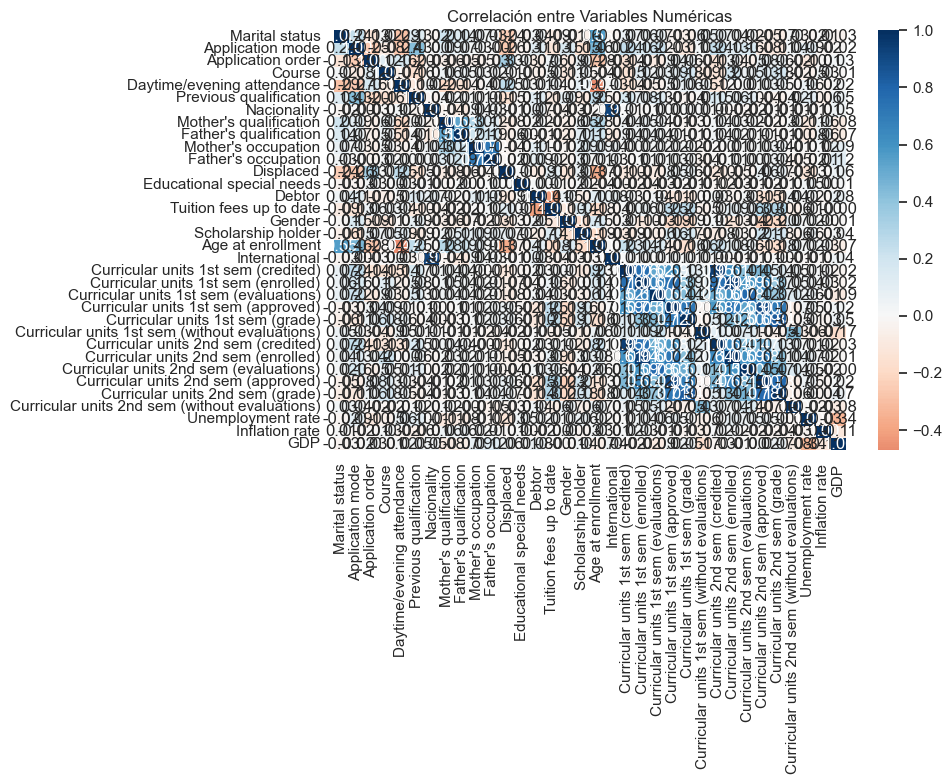

C:\Users\Fhuan\AppData\Local\Temp\ipykernel_19048\4063297673.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_grouped.values, y=top10_grouped.index, palette="crest")


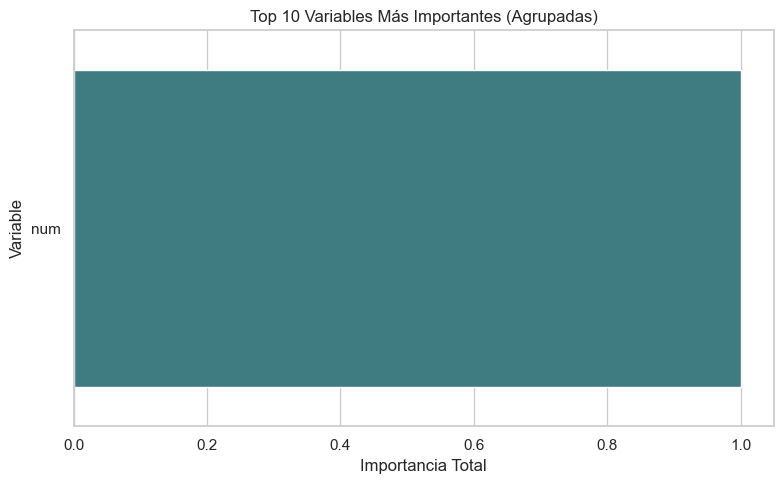

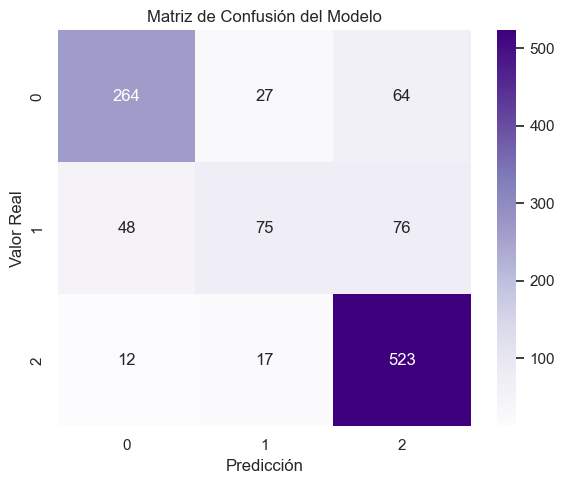

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

sns.set(style="whitegrid")

# ============================================================
# 1. Distribución de la variable Target
# ============================================================
plt.figure(figsize=(6,4))
sns.countplot(x="Target", data=df, palette="Set2")
plt.title("Distribución de Estudiantes por Clase (Target)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de Estudiantes")
plt.tight_layout()
plt.show()

# ============================================================
# 2. Boxplot de Edad por Target
# ============================================================
if "Age at enrollment" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Target", y="Age at enrollment", data=df, palette="Set3")
    plt.title("Distribución de Edad por Clase de Estudiantes")
    plt.tight_layout()
    plt.show()

# ============================================================
# 3. Violin plot de notas 1er semestre por Target
# ============================================================
if "curricular units 1st sem (grade)" in df.columns:
    plt.figure(figsize=(6,4))
    sns.violinplot(x="Target", y="curricular units 1st sem (grade)", data=df, palette="coolwarm", cut=0)
    plt.title("Distribución de Calificaciones 1er Semestre por Target")
    plt.tight_layout()
    plt.show()

# ============================================================
# 4. Heatmap de correlación entre variables numéricas
# ============================================================
num_cols = df.select_dtypes(include=["int64","float64"]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="RdBu", center=0)
plt.title("Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

# ============================================================
# 5. Top 10 variables más importantes del modelo (importancia agrupada por variable original)
# ============================================================

# Agrupar importancias de variables (OneHot a variable original)
imp_df = pd.DataFrame({
    "feature": full_feature_names,
    "importance": importances
})
imp_df["original_feature"] = imp_df["feature"].apply(lambda f: f.split("_")[0] if f not in num_cols else f)
grouped_imp = imp_df.groupby("original_feature")["importance"].sum().sort_values(ascending=False)
top10_grouped = grouped_imp.head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top10_grouped.values, y=top10_grouped.index, palette="crest")
plt.title("Top 10 Variables Más Importantes (Agrupadas)")
plt.xlabel("Importancia Total")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# ============================================================
# 6. Matriz de confusión del modelo
# ============================================================
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusión del Modelo")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()
